In [4]:
import fonctions as f
dataSerie = f.pd.read_csv("dataMod.csv", index_col =["DATE"] , parse_dates = ["DATE"])
dataSerie.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1022 entries, 2022-01-05 to 2024-10-31
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RR          1022 non-null   float64
 1   TN          1022 non-null   float64
 2   HTN         1022 non-null   float64
 3   TX          1022 non-null   float64
 4   HTX         1022 non-null   float64
 5   TM          1022 non-null   float64
 6   TMNX        1022 non-null   float64
 7   DG          1022 non-null   float64
 8   TAMPLI      1022 non-null   float64
 9   TNTXM       1022 non-null   float64
 10  FFM         1022 non-null   float64
 11  FXI         1022 non-null   float64
 12  DXI         1022 non-null   float64
 13  HXI         1022 non-null   float64
 14  FXY         1022 non-null   float64
 15  DXY         1022 non-null   float64
 16  HXY         1022 non-null   float64
 17  FXI3S       1022 non-null   float64
 18  HXI3S       1022 non-null   float64
 19  UN       

In [6]:
#On divise la base en une partie test et une partie apprentissage
train_size = int(len(dataSerie) * 0.8)
train, test = dataSerie[:train_size], dataSerie[train_size:]

(array([18993., 19113., 19236., 19358., 19478., 19601., 19723., 19844.,
        19967.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09')])

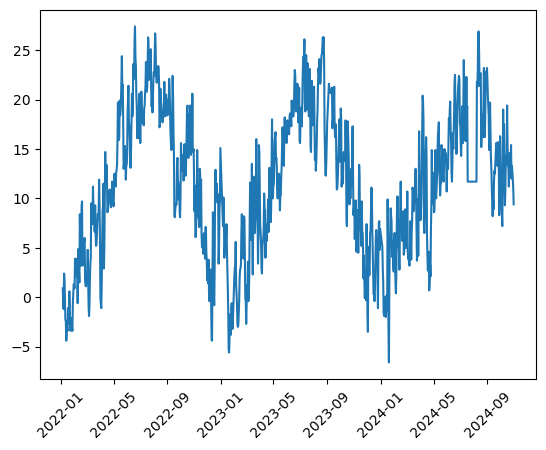

In [ ]:
#Visualtion de la série
f.plt.plot(dataSerie.index, dataSerie['TM'])
f.plt.xticks(rotation=45)

# Vérification de la stationnarité
Vérifier la stationnarité est une étape cruciale dans l'analyse des séries temporelles, car de nombreux modèles statistiques et de machine learning (comme ARIMA, SARIMA ou même certains modèles de régression) supposent que les données sont stationnaires pour produire des résultats fiables. 
Le test de Dickey-Fuller : il s'agit de l'un des tests statistiques permettant de vérifier la stationnarité. Ici, l'hypothèse nulle est que la série TS n'est pas stationnaire. Les résultats du test comprennent une statistique de test et des  valeurs critiques pour les niveaux de confiance des différences. Si la « statistique de test » est inférieure à la « valeur critique », nous pouvons rejeter l'hypothèse nulle et dire que la série est stationnaire.

In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = f.pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
#On teste la stationnarité du modèle

test_stationarity(train["TM"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.790458
p-value                          0.059650
#Lags Used                       6.000000
Number of Observations Used    714.000000
Critical Value (1%)             -3.439542
Critical Value (5%)             -2.865596
Critical Value (10%)            -2.568930
dtype: float64


La statistique du test de Dickey-Fuller est inférieure à la valeur critique de 10 % , donc cette série est stationnaire avec une confiance de 90 %.

Par la suite  décomposition est une méthode utilisée pour séparer une série temporelle en ses composantes fondamentales : tendance, saisonnalité et résidu.

y(t)= Niveau+Tendance+Saisonnalité+Bruit


# la Tendance

In [6]:
moving_avg = train["TM"].rolling(window=12).mean()
plt.plot(train["TM"])
plt.plot(moving_avg, color='red')
moving_avg.head(12)

NameError: name 'plt' is not defined

En prenant une fenêtre de 12, 24 mois, une tendance est bien visible. Par ailleurs, le fait que cette tendance est identifiable pour des fenêtres glissantes dont la taille est un multiple de 12 mois suggère une notion de saisonnalité.

# Saisonnalité

La saisonnalité désigne les tendances hebdomadaires, mensuelles, trimestrielles ou annuelles. Ce sont les motifs qui se répètent sur une durée infra-annuelle. Il semble qu'on ait ici une saisonnalité annuelle. Une manière visuelle de vérifier l'effet saisonnier est de tracer une courbe pour chaque année en prenant les mois comme abscisses et visualiser ainsi la répartition des passagers au cours de chaque année.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 14, 10
f.plt.style.use('fivethirtyeight')
températures = train["TM"]

# period est le nombre de points de données dans un cycle répété.
result = seasonal_decompose(températures, model='additive', period=)
result.plot()
plt.show()

ValueError: x must have 2 complete cycles requires 730 observations. x only has 721 observation(s)

In [57]:
residual=result.resid
residual.dropna(inplace=True)
test_stationarity(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.079574e+01
p-value                        2.077861e-19
#Lags Used                     1.800000e+01
Number of Observations Used    6.900000e+02
Critical Value (1%)           -3.439863e+00
Critical Value (5%)           -2.865738e+00
Critical Value (10%)          -2.569005e+00
dtype: float64


La statistique du test de Dickey-Fuller est significativement inférieure à la valeur critique de 1 % . Cette série est donc très proche de la stationnarité

# ACF et PACF test
Nombre de termes AR (autorégressifs) (p) : les termes AR ne sont que des décalages de la variable dépendante. Par exemple, si p est 5, les prédicteurs pour x(t) seront x(t-1)….x(t-5).
Nombre de termes MA (moyenne mobile) (q) : les termes MA sont des erreurs de prévision décalées dans l'équation de prédiction. Par exemple, si q est 5, les prédicteurs pour x(t) seront e(t-1)….e(t-5) où e(i) est la différence entre la moyenne mobile au i ème instant et la valeur réelle.
Nombre de différences (d) : il s'agit du nombre de différences non saisonnières, c'est-à-dire que dans ce cas, nous avons pris la différence de premier ordre. Nous pouvons donc soit passer cette variable et mettre d=0, soit passer la variable d'origine et mettre d=1. Les deux généreront les mêmes résultats.
Une question importante ici est de savoir comment déterminer la valeur de « p » et « q ». Nous utilisons deux tracés pour déterminer ces nombres. Commençons par les examiner.

Fonction d'autocorrélation (ACF) : Il s'agit d'une mesure de la corrélation entre le TS et une version retardée de lui-même. Par exemple, à un décalage de 5, l'ACF comparerait la série à l'instant 't1'…'t2' avec la série à l'instant 't1-5'…'t2-5' (t1-5 et t2 étant les points finaux).
Fonction d'autocorrélation partielle (PACF) : elle mesure la corrélation entre le TS et une version décalée de lui-même, mais après avoir éliminé les variations déjà expliquées par les comparaisons intermédiaires. Par exemple, au décalage de 5, elle vérifiera la corrélation mais supprimera les effets déjà expliqués par les décalages de 1 à 4.


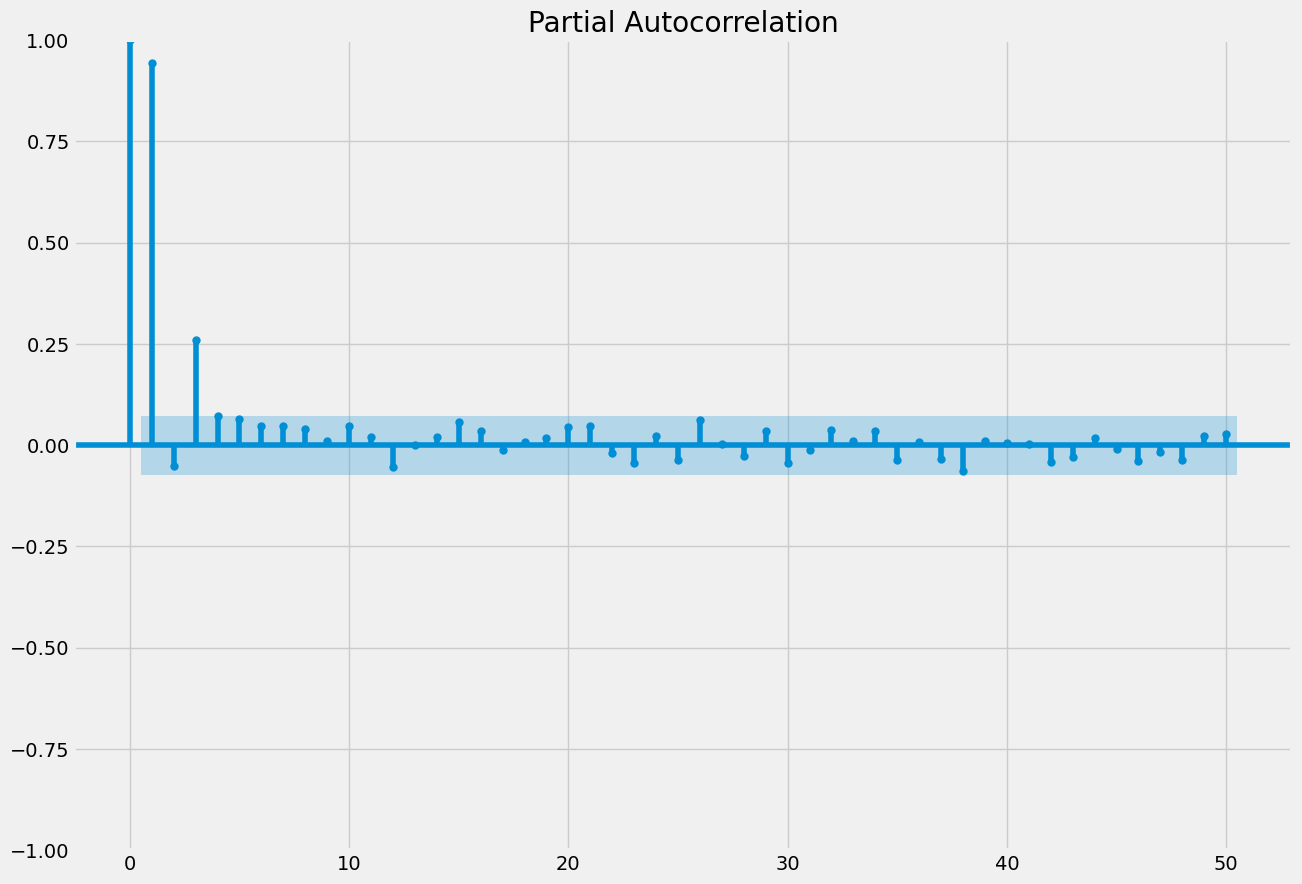

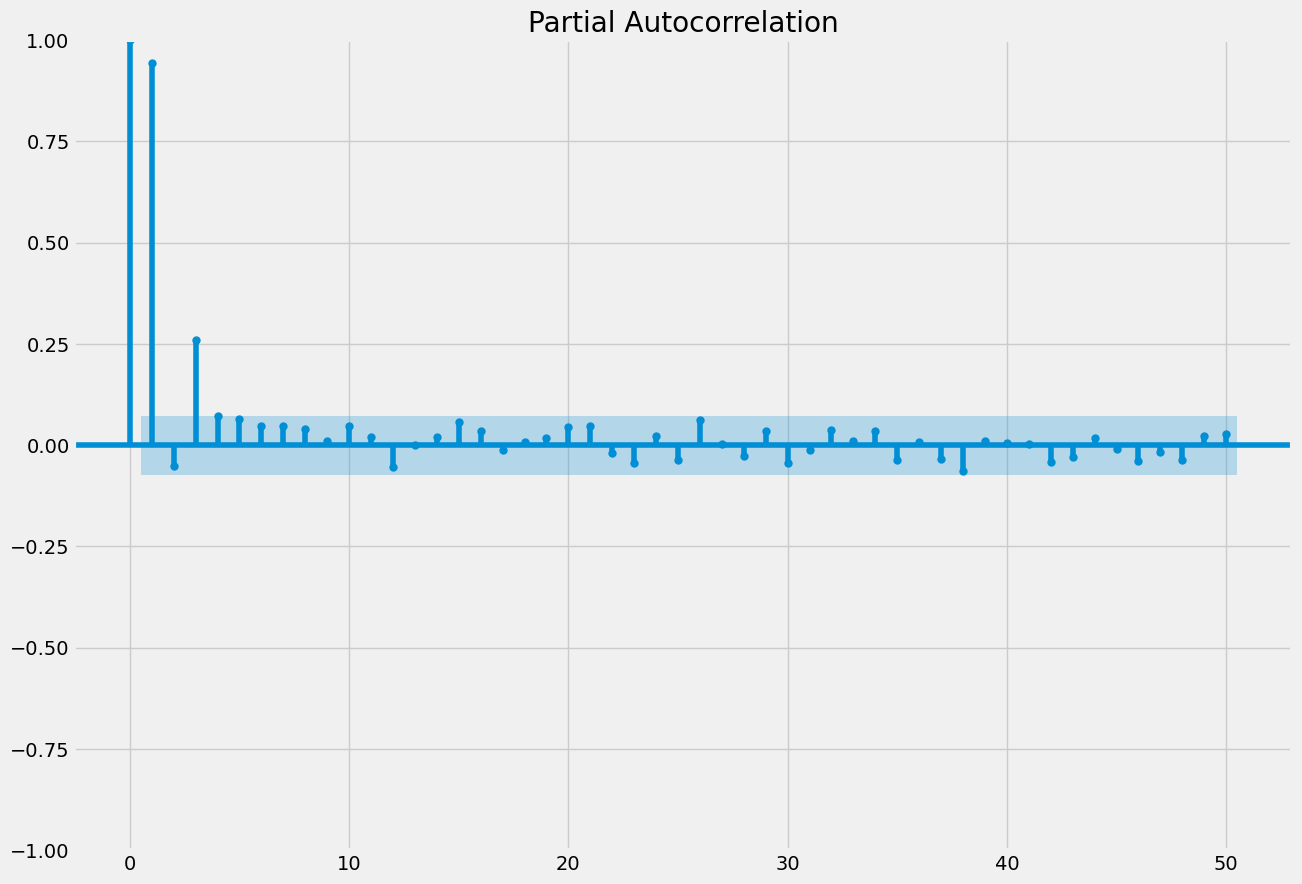

In [131]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_pacf(train["TM"], lags=50)

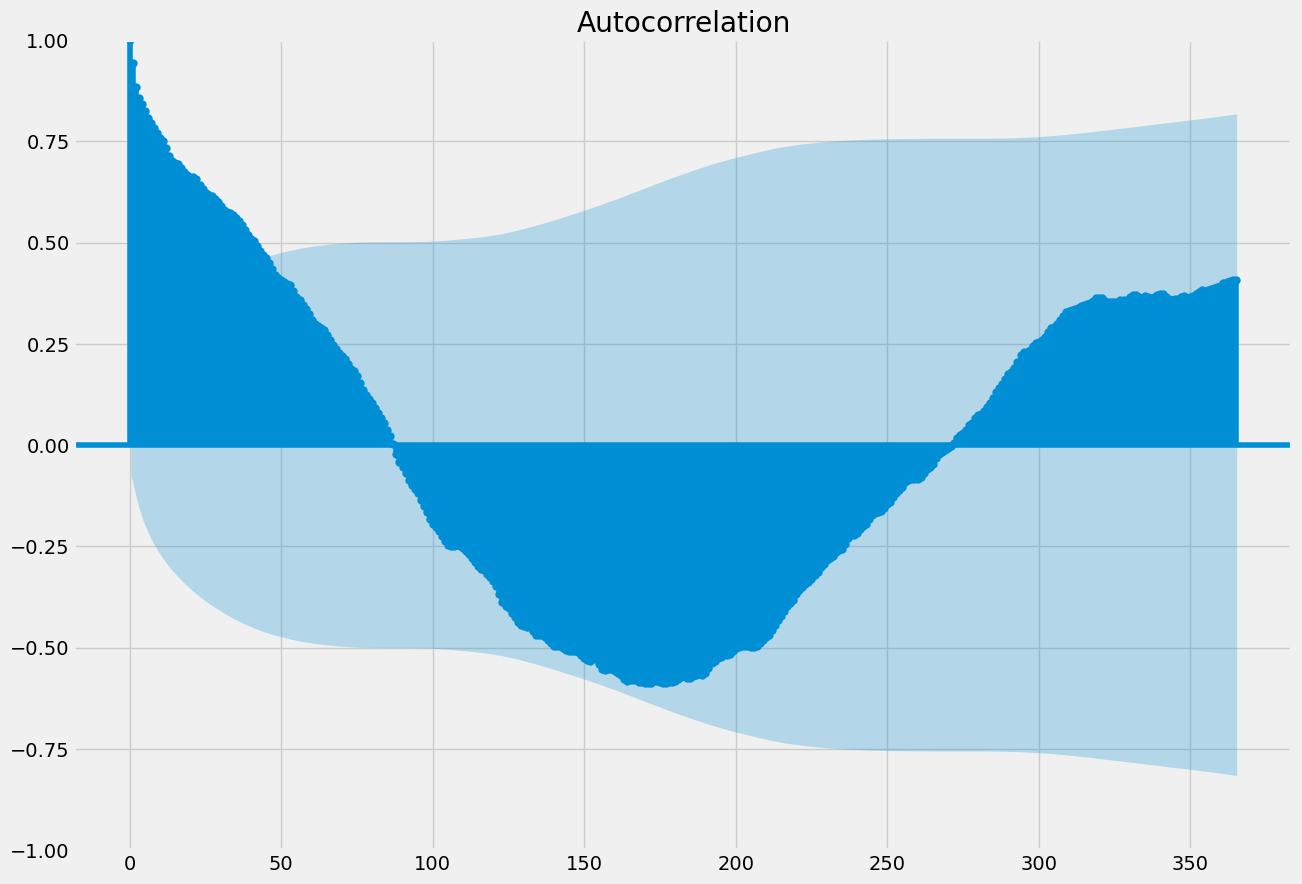

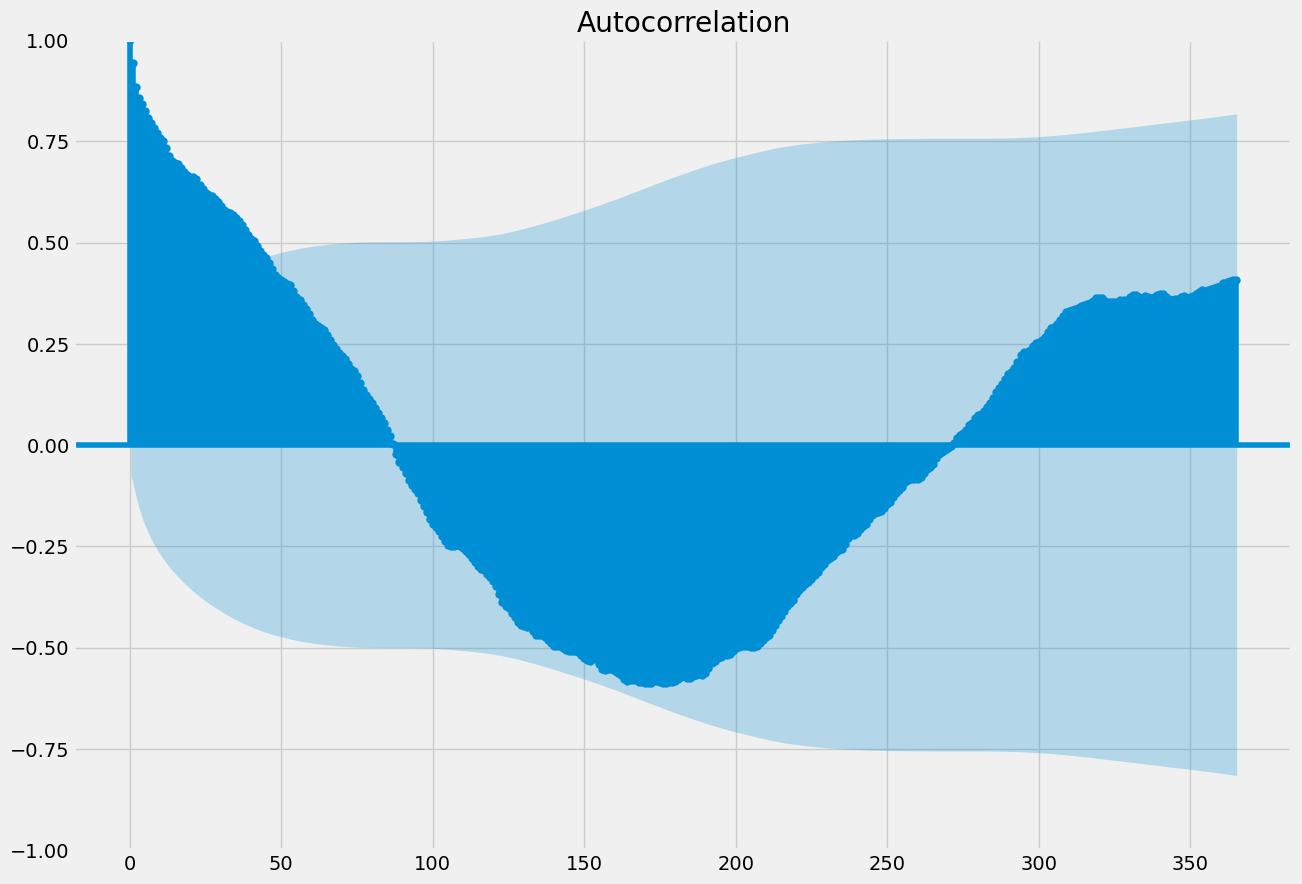

In [126]:
plot_acf(train["TM"], lags=365)